In [76]:
#!conda install -c conda-forge python-docx seaborn

In [77]:
%load_ext autoreload
%aimport model
%autoreload 2
import pickle
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [79]:
from docplex.mp.environment import Environment
Environment().print_information()

* system is: Darwin 64bit
* Python version 3.9.13, located at: /opt/anaconda3/bin/python
* docplex is present, version is 2.25.236
* CPLEX library is present, version is 22.1.1.0, located at: /opt/anaconda3/lib/python3.9/site-packages
* pandas is present, version is 1.4.4


In [80]:
from docplex.mp.conflict_refiner import ConflictRefiner
from docplex.mp.relaxer import Relaxer

In [81]:
# redondant dans prepross_power
def year_month_date_to_string(date):
    return date.strftime('%Y%m')

def datetime_attributes(df, column, attribute=['year', 'month', 'day', 'hour', 'dayofyear', 'quarter']):
    # define generator expression of series, one for each attribute
    date_gen = (getattr(df[column].dt, i).rename(i) for i in attribute)
    return pd.concat(date_gen, axis=1)

def datetime_isocalendar(df, column, attribute=['year','week', 'weekday']):
    date_gen =  df.apply(lambda x: x[column].isocalendar(), axis=1, result_type='expand')
    date_gen = date_gen.rename(columns= dict((i,j) for i,j in enumerate(attribute)))
    date_gen['is_workday'] = date_gen['weekday'].apply(lambda  x: 1 if x<6 else 0)
    #date_gen['workday'] =  1 if date_gen['weekday']<6 else 0
    print(date_gen.head())
    return date_gen

In [82]:
def generate_Si(dataf, start, stop,name):
    d = pd.DataFrame(index=dataf.index)
    for i, (b, e) in enumerate(zip(start,stop)):
        ts = dataf.between_time(b, e)
        n = name+str(i+1)
        #try:
        d.loc[dataf.index,n] = 0

        #except:
        #    pass
        d.loc[ts.index,n] = np.where((ts['is_workday'] ==1), 1, 0)
        #d.loc[ts.index,n] = np.where((ts['is_workday'] >=0), 1, 0)
    return d.copy(True)

In [83]:
sns.set_style("whitegrid")
figure_size =[20,6]
save_dir = 'media'

In [84]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
invalid = '<>:"/\|?* '

In [85]:
filename = "ConsommationUniversite.pickle"
df = pd.read_pickle(filename)
print(df.shape)
year = df['year'].unique()
print(year)
print(df.columns)
print(max(df['Power [kW]']),max(df['Power Clipped [kW]']))

(69504, 16)
[2015 2016]
Index(['Timestamp', 'Power [kW]', 't', 'year', 'month', 'day', 'hour', 'dayofyear', 'quarter', 'week', 'weekday', 'is_workday', 'year_month', 'month_week', 'Power Clipped [kW]', 'is_peak'], dtype='object')
12442.0 2442.0


In [86]:
df['time'] = df.index

# <font color='blue'> Définition de la période d'étude </font>

Changer les valeurs de 'period_begin' et 'period_end' pour la période désirée.  Choisir la source (colonne) de puissance avec 'POWER_FOR_Pb' pour travailler.

In [87]:
period_begin = '2015-01-12'
period_end = '2015-01-14'
#period_end = '2015-12-31'

#period_begin = '2015-01-01'
#period_end = '2016-12-31'

#an = df[df['year'] == year[0]]

# 2015-09-09 12:14:00 2015-09-09 07:14:0

Si_gen = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

#Si_gen = generate_Si(df,
#                 start=['07:30', '10:00', '08:00', '13:00'],
#                 stop=['17:00', '15:00', '12:30', '20:30'],name='Si_')

# Si_gen = generate_Si(df,
#                  start=['08:00','08:00','08:00','08:00' ],
#                  stop=['20:00','20:00','20:00','20:00'],name='Si_')
#print(Si_gen)

an = pd.concat([df, Si_gen], axis=1)
#an = an[(an['week'] == 3) & (an['year'] == 2015)]


POWER_FOR_Pb = 'Power [kW]'
#POWER_FOR_Pb = 'Power Clipped [kW]'
Pb = an[POWER_FOR_Pb].loc[period_begin:period_end]
idx = Pb.index
Pb = Pb.to_numpy(copy=True)
Si = Si_gen.loc[period_begin:period_end]
Si = Si.astype(float).to_numpy(copy=True)

Si_tot = np.amax(Si, axis=1)

#df2 = an.loc[period_begin:period_end]
#df2 = an
print(Pb.shape, Si.shape, Si_tot.shape)

l = Pb.shape[0]
print("maximum de Pb(t) :{m} avec T={t}".format(m=max(Pb), t=l))

arrivee = []
depart = []
for sign in Si.T:
    # JUMP
    thres = 0.5
    si = sign
    y = np.where(np.logical_and(si>-thres,si<thres), 0, 1) # ACTIVITY

    der_y = np.diff(y)
    higherPeaks = np.where(der_y>=1)[0]
    lowerPeaks = np.where(der_y<=-1)[0]
    arrivee.append(higherPeaks)
    depart.append(lowerPeaks)
    # plt.figure()
    # plt.plot(si)
    # plt.plot(higherPeaks, si[higherPeaks], 'ro')
    # plt.plot(lowerPeaks, si[lowerPeaks], 'ko')

(288,) (288, 4) (288,)
maximum de Pb(t) :11334.0 avec T=288


In [88]:
df_grp_ym = an.loc[period_begin:period_end].groupby(by='year_month').agg({'Power Clipped [kW]':'max', 'Power [kW]':'max','year':'max','month':'max','day':['nunique','idxmin','idxmax']
                                              ,'t':['min','max']
                                                   }).reset_index('year_month')
df_grp_ym.columns = df_grp_ym.columns.to_flat_index()
display(df_grp_ym)
Pb_max__m = df_grp_ym[POWER_FOR_Pb,'max'].to_numpy(copy=True)

t_min__m = df_grp_ym['t','min'].to_numpy(copy=True)
t_max__m = df_grp_ym['t','max'].to_numpy(copy=True)
print(Pb_max__m)
print(t_min__m)
print(t_max__m)

,"(year_month, )","(Power Clipped [kW], max)","(Power [kW], max)","(year, max)","(month, max)","(day, nunique)","(day, idxmin)","(day, idxmax)","(t, min)","(t, max)"
0,201501,1334.0,11334.0,2015,1,3,2015-01-12 00:14:00,2015-01-14 00:14:00,384,671


[11334.]
[384]
[671]


# <font color='blue'> Définition des Paramètres du modèle </font>

In [89]:
print('Set problem parameters')
n_ev = 1600.0

# Prius 4.4kWh, Leaf 24kWh
soc_max = 48#0.8*24*n_ev
soc_min = 9#0.2*4.4*n_ev
print("{mi} <= SOC <= {ma}".format(mi=soc_min, ma=soc_max))

params = {
    # Variables	Descriptions	Unités
    'C__E': 0.003830, # Coût de l'énergie $/kW
    'C__P': 14.677, # Coût de la puissance $/kW
    'C__b_n': np.tile(np.array([[0.0196], [0.268]]),4), # Coût de l'infrastructure N $/delta_t
    'SOCmin': soc_min,  # État de charge minimum des véhicules électriques	kWh
    'SOCmax': soc_max,  # État de charge maximum des véhicules électriques	kWh
    'Pch_min': 0,#(4.4*(15/60)),  # Puissance de charge minimum 	kW
    'Pdis_min': 0,#(4.4*(15/60)),  # Puissance de décharge minimum	kW
    'Pch_max_n': [10, 63], #[bn*7.5, bn*50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    'Pdis_max_n': [10, 63], #[bn*5.0, bn*40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW
    'beta_ch': 0.93,  # Efficacité de charge_
    # 	%
    'beta_dis': 0.93,  # Efficacité de décharge	%
    'NEVs': n_ev,  # Nombre de véhicules électriques	Qté
    'Rut': [0.42, 0.01, 0.19, 0.38],  # Ratio d’utilisateurs avec le profil i	%
    'delta_t': 15 / 60,  # 15mins
    'MAX_OPTIM': 1e7,  # Facteur majorant du programme d'optimisation

    'Pb': Pb,  # Puissance appelée par le bâtiment appelée à l’instant t	kW
    'Pb_max__m': Pb_max__m, # Puissance maximale du bâtiment par mois
    'P_souscrite' : 10000, # Puissance souscrite avec Hydro-Québec
    'Si': Si, #1, Si le profil d’utilisateur est raccordé à une borne à l’instant t

    't_min__m': t_min__m, # indice du premier échantillon t du mois m
    't_max__m': t_max__m, # indice du dernier échantillon t du mois m

    'arrivee':arrivee, # indices des échantillons t d'arrivées sur la période T
    'depart':depart, # indices des échantillons t de départ sur la période T
}

Set problem parameters
9 <= SOC <= 48


In [175]:
#%aimport model
#more: https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution
mdl = model.ModelShaving('V2B', params=params)
mdl.problem_variables()
mdl.problem_constraints() # Contraintes de base sut SOC, Pch, Pdis, delta selon n,i,t
mdl.cout_energie = mdl.problem_cout_energie()
mdl.cout_puissance = mdl.problem_cout_puissance()
mdl.cout_infrastructure = mdl.problem_cout_infrastructure()
f_objective = mdl.cout_energie+mdl.cout_puissance+mdl.cout_infrastructure
mdl.minimize(f_objective)
# TODO: mettre les problem_cout_... en vecteurs/retirer la dernière somme pour avoir min et max
mdl.add_kpi(mdl.cout_energie, "Cout Energie ($)")
mdl.add_kpi(mdl.cout_puissance, "Cout Puissance ($)")
mdl.add_kpi(mdl.cout_infrastructure, "Cout infrastructure ($)")
mdl.add_kpi(mdl.max(mdl.params['Pb_max__m']), "max Puissance Pb_max[m] clipped (kW)")
mdl.add_kpi(mdl.max(mdl.Pr__t), "max Puissance Preseau clipped (kW)")


mdl.problem_constraint_SOC__n_i_t_arrivee()
mdl.problem_constraint_SOC__n_i_t_depart()
#mdl.problem_constraint_SOC__n_i_t_arrivee_depart()
#mdl.problem_constraint_uc_connexion_deconnection() # actuellement non utilisé (remplacé par arrivee , depart )

#mdl.ctr_Pr__t = mdl.problem_constraint_Pr__t()

#mdl.problem_constraint_SOC__n_i_t() # Bloque les autres, mais sans delta delta_ch/dis__n_i_t
#mdl.problem_constraint_SOC__v2_n_i_t()
mdl.problem_constraint_SOC__v3_n_i_t()
mdl.problem_constraint_Pr__t_v3()

mdl.problem_constraint_Pess__t_v3()
mdl.problem_constraint_Pess_range_v3()
#mdl.add_constraint(mdl.Pess__t[0] == 0,'P_ess_t_0_equal_0')
[mdl.add_constraint(mdl.Pess__n_i_t[n,i,t] * (1-mdl.params['Si'][t - 1, i - 1]) == 0) for n in mdl.ens['N'] for i in mdl.ens['I'] for t in mdl.ens['T']]



mdl.problem_constraint_Pch_total__t()
mdl.problem_constraint_Pdis_total__t()
mdl.problem_constraint_Pr_t__max__m()

mdl.problem_constraint_prevent_simultaneous_charge_and_discharge_i_t()
mdl.problem_constraint_Pr_t__threshold__m()
#mdl.problem_constraint_Pr__n_i_t()

# ceci est nouveau
#mdl.problem_constraint_uc_soc_ramp_up_and_soc_ramp_down() # autre façon pour le SOC mais sans ch & desch
#mdl.problem_constraint_SOC__n_i_t_latch_on() # Le faire pour charge/discharge ?!

print('\n')
mdl.print_information()
solus = mdl.solve(log_output=True)
assert solus is not None, "!!! Solve of the model fails"
print("*"*50)
print("Obj", mdl.solution.get_objective_value())
#mdl.print_solution(print_zeros=False)
print("-"*50)
mdl.report()
print("-"*50)
print('end')
#with open('solution.pickle', mode='wb') as f:
#    pickle.dump(solus, f)
#filename = Path(save_dir,'solution.json')
#with open('solution.json', mode='wb') as f:
#    solus.export(f,format='json')

cr = ConflictRefiner()
crr = cr.refine_conflict(mdl, display=True)
print("="*50)
rx = Relaxer()
rs = rx.relax(mdl)
rx.print_information()
#rs.display()
print("+"*50)

{'utilsateur': 4, 'borne': 2, 'instant': 288, 'mois': 1, 'I': range(1, 5), 'N': range(1, 3), 'T': range(0, 288), 'M': range(0, 1)}
0 0 288
0 0 288


Model: V2B
 - number of variables: 17569
   - binary=2592, integer=0, continuous=14977
 - number of constraints: 16212
   - linear=16212
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 169740.270530 after 0.00 sec. (1.86 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 15294 rows and 25485 columns.
Aggregator did 288 substitutions.
Reduced MIP has 630 rows, 1012 columns, and 2130 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (17.87 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 630 rows, 1012 columns, and 2130 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 

In [176]:
#df_Rborne__n_i = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Rborne__n_i,
#                                 index='i', columns='n')
#print(df_Rborne__n_i)

Setting constraint priorities explicitly is the most basic way to control relaxation, but there are others. A _function_ can be used: the relaxer will call the function for each constraint to determine its priority. Possible values are:

  - relaxable priorities: VERY_LOW, LOW, MEDIUM, HIGH, VERY_HIGH
  - non-relaxable priority: MANDATORY

Constraints with higher priority are less likely to be relaxed than constraints with lower priorities. Still, relaxation of a high-priority constraint cannot be ruled out, if it is the only way to provide a relaxed solution.

In [177]:
dk = pd.DataFrame({'Pb batiment': mdl.params['Pb'],
                   'Pr reseau': solus.get_value_list(mdl.Pr__t),
                   'P charge totale': solus.get_value_list(mdl.Pch_tot__t),
                   'P décharge totale': solus.get_value_list(mdl.Pdis_tot__t),
                   'P ESS totale': solus.get_value_list(mdl.Pess__t),
                   'Si': Si_tot,
                   #'t':idx
                   }
                  ).set_index(idx)
#dk.to_csv('resultats.csv')

/var/folders/ml/k9khjmr57qqcw3y03b7k154c0000gn/T/ipykernel_9304/907409636.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  g = dk.plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)


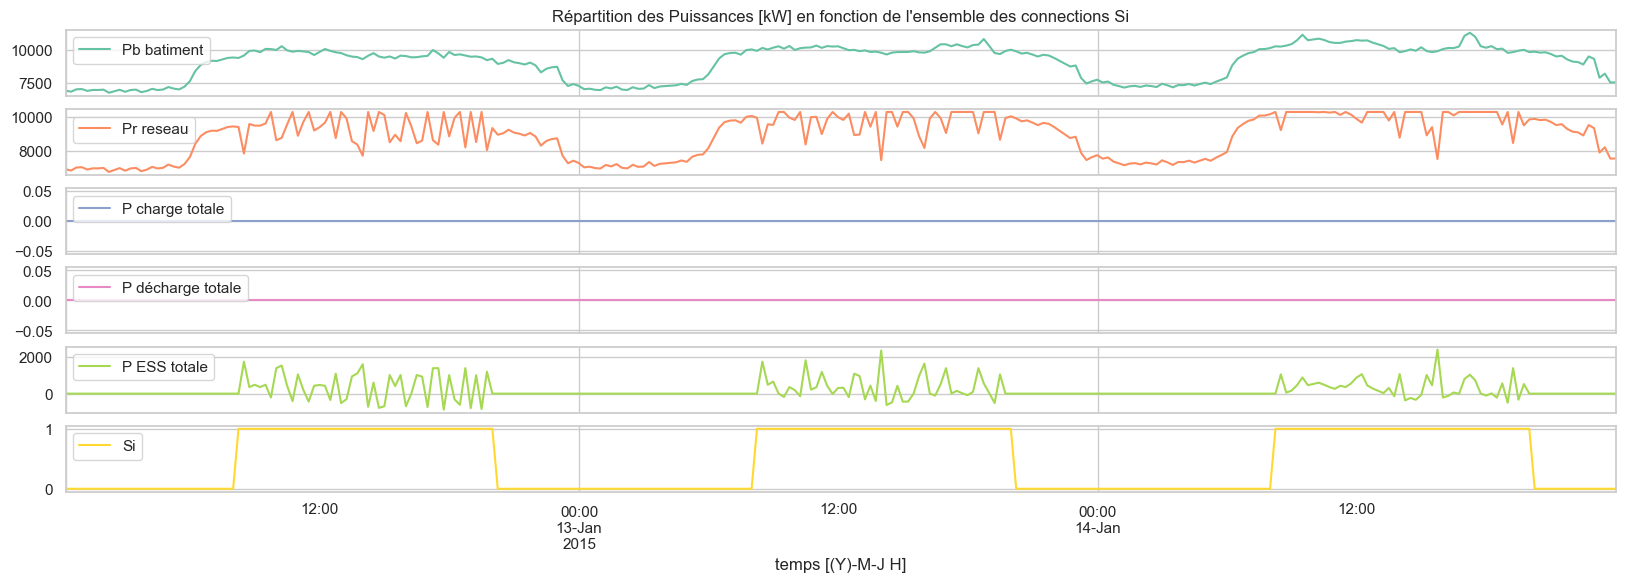

In [178]:
title = "Répartition des Puissances [kW] en fonction de l'ensemble des connections Si"
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figure_size, sharex=True)
fig1 = ax.get_figure()
g = dk.plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)
for i in g:
    i.legend(loc='upper left')
g[0].set_title(title)
g[-1].set_xlabel('temps [(Y)-M-J H]')
#for char in invalid:
#	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,title+'.png')

plt.show()

fig1.savefig(filename, format='png', dpi=200, bbox_inches='tight')

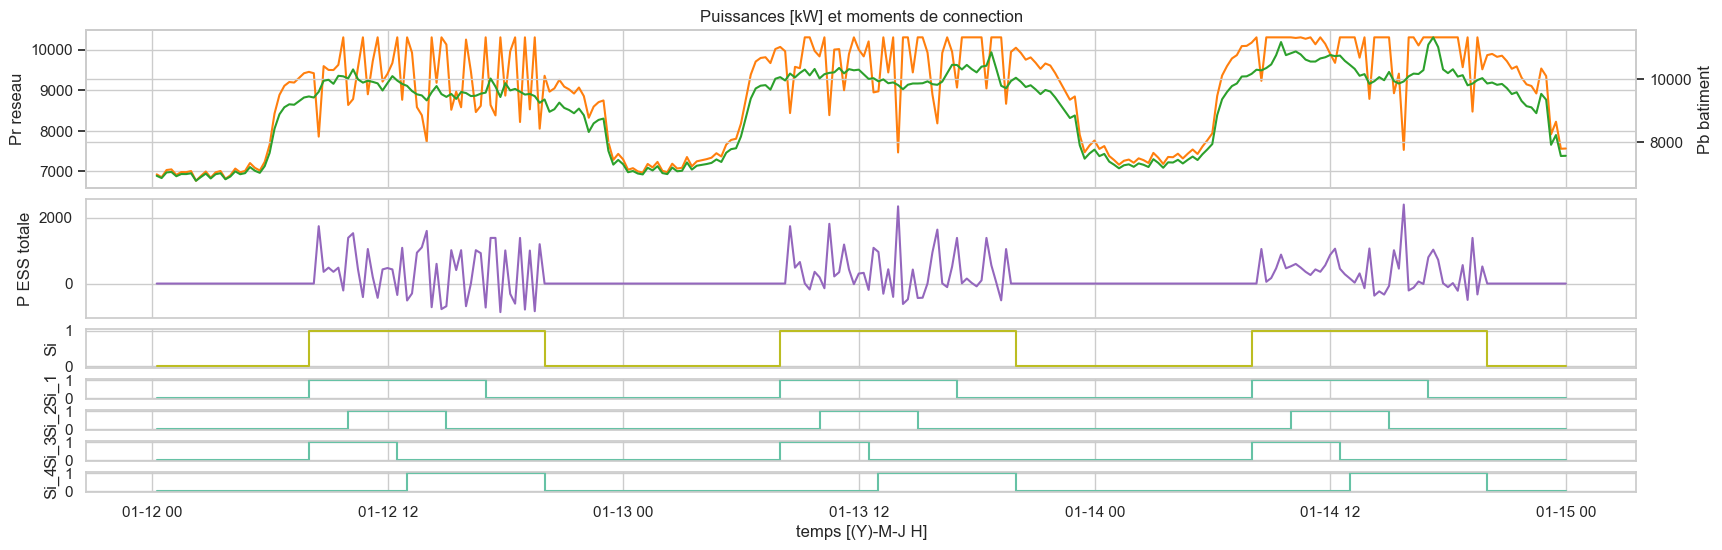

In [179]:
title = 'Puissances [kW] et moments de connection'
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=7, figsize=figure_size, sharex=True,
                        gridspec_kw={'height_ratios': [2.0, 1.5, 0.5, 0.25, 0.25, 0.25, 0.25]})

g = sns.lineplot(x=dk.index, y='Pr reseau', estimator='max', data=dk,  ax=axs[0], color='tab:orange')
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='Pb batiment', estimator='max', data=dk, ax=ax2, color='tab:green',dashes=True)

#g = sns.lineplot(x=dk.index, y='P décharge totale', estimator='max', data=dk,  ax=axs[1], color='tab:purple', dashes=True)
#ax2 = g.twinx()
#h = sns.lineplot(x=dk.index, y='P charge totale', estimator='max', data=dk, ax=ax2, color='tab:pink', dashes=True)


g = sns.lineplot(x=dk.index, y='P ESS totale', estimator='max', data=dk,  ax=axs[1], color='tab:purple', dashes=True)

#g.set_yticklabels(g.get_yticklabels(), rotation=45)
#h.set_yticklabels(h.get_yticklabels(), rotation=45)

#g.tick_params(axis='y', labelrotation = 45)

what = 't'
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[2], drawstyle="steps", color="tab:olive")
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[5], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[6], drawstyle="steps")
axs[6].set_xlabel('temps [(Y)-M-J H]')
for a in range(3, 7):
    axs[a].set_yticks([0, 1])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


2015-01-14 17:14:00 2015-01-12 10:44:00


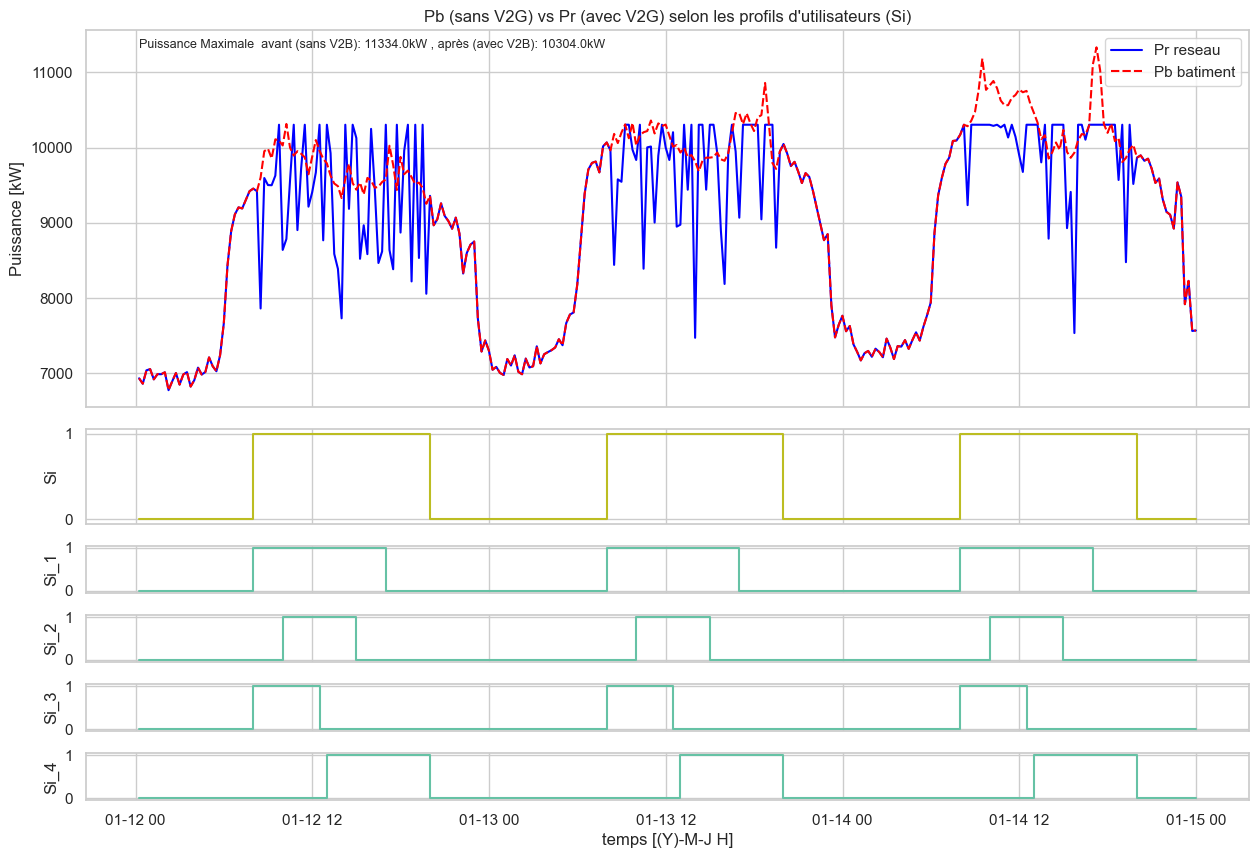

Puissance Maximale  avant (sans V2B): 11334.0kW , après (avec V2B): 10304.0kW 


In [180]:
text = 'Puissance Maximale  avant (sans V2B): {b}kW , après (avec V2B): {r}kW '.format(b=dk['Pb batiment'].max(), r=dk['Pr reseau'].max() )

idb_max = dk['Pb batiment'].idxmax()
idr_max = dk['Pr reseau'].idxmax()
print(idb_max, idr_max)
# 2015-09-09 12:14:00 2015-09-09 07:14:0     :: Mercredi

title = "Pb (sans V2G) vs Pr (avec V2G) selon les profils d'utilisateurs (Si)"
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15,10), sharex=True, gridspec_kw={'height_ratios': [2, 0.5,0.25, 0.25, 0.25, 0.25]})
g = sns.lineplot(data=dk[['Pr reseau','Pb batiment']],  ax=axs[0], palette=['b','r'])
axs[0].text(dk.index[0], dk['Pb batiment'][idb_max], text, fontsize=9)
axs[0].set_ylabel('Puissance [kW]')
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[1], drawstyle="steps", color='tab:olive')
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[2], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[5], drawstyle="steps")
axs[5].set_xlabel('temps [(Y)-M-J H]')
for a in range(1,6):
    axs[a].set_yticks([0, 1])
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


print(text)

In [181]:
df_Pch__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pch__i_t__')
df_Pdis__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pdis__i_t__')
df_SOC__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.SOC__n_i_t, index='t', columns=['n', 'i'])


df_Pess__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pess__n_i_t, index='t', columns=['n', 'i'])

#print(df_Pch__i_t)
#print(df_Pdis__i_t)
#df_SOC__n_i_t.rename(mapper=lambda x: f'N_{x}', axis='columns', level=0, inplace=True)
#df_SOC__n_i_t.rename(mapper=lambda x: f'I_{x}', axis='columns', level=1, inplace=True)
#print(df_SOC__n_i_t)

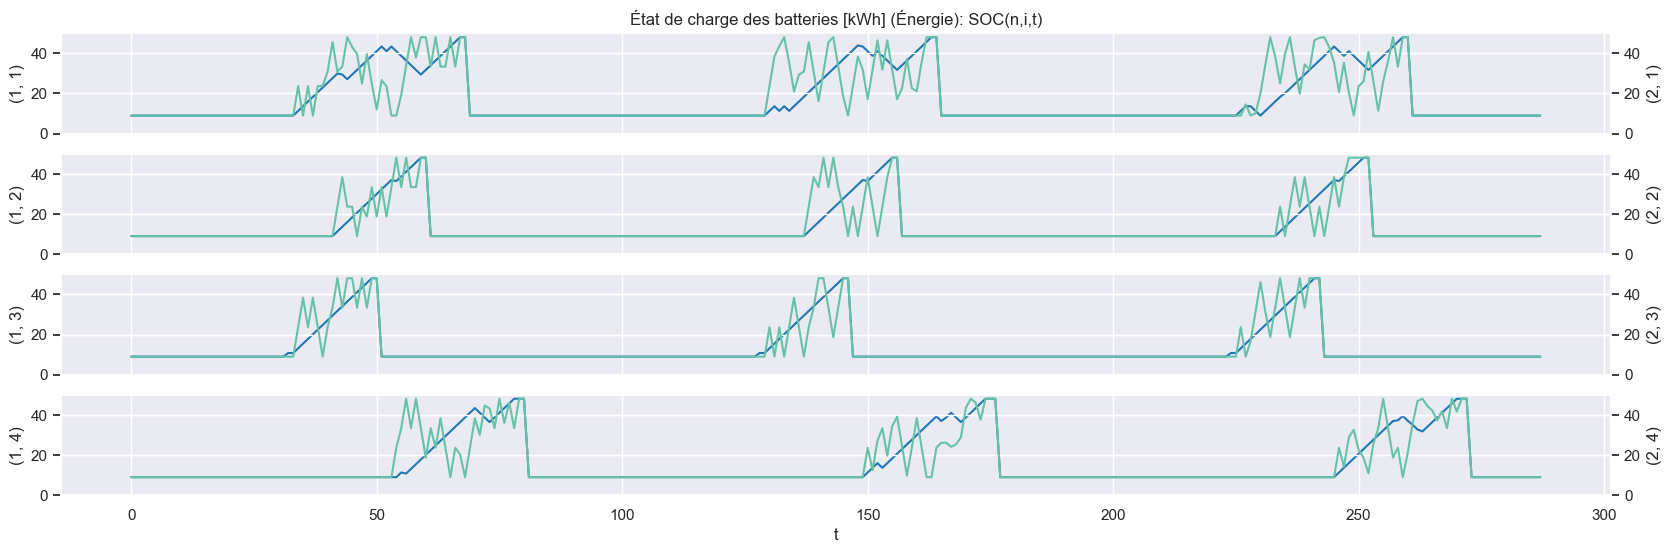

In [182]:
# Error Bands + valeur maximale des mois
title = "État de charge des batteries [kWh] (Énergie): SOC(n,i,t)"
what= 't'
#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_SOC__n_i_t,  ax=axs[0],color='tab:blue')
g.set(ylim=(0, None))
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_SOC__n_i_t, ax=ax2)
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_SOC__n_i_t, ax=axs[1],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_SOC__n_i_t, ax=axs[2],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_SOC__n_i_t, ax=axs[3],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


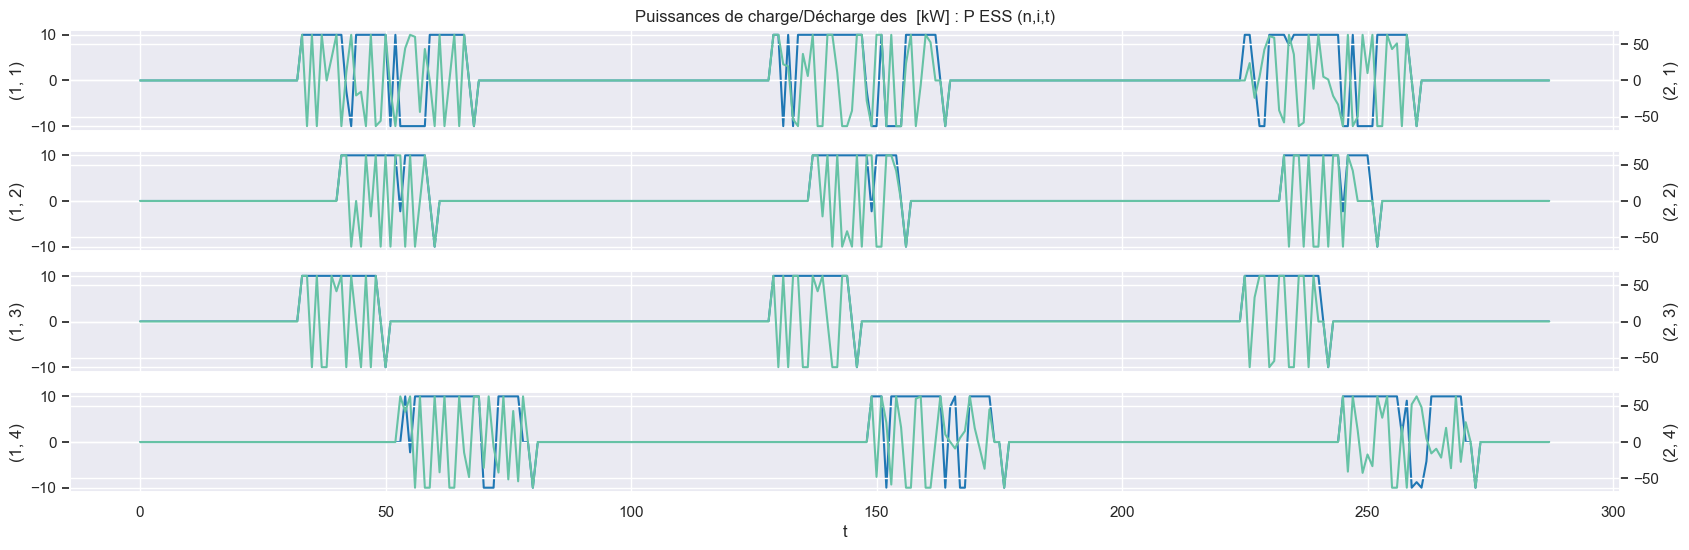

In [183]:
# Error Bands + valeur maximale des mois
title = "Puissances de charge/Décharge des  [kW] : P ESS (n,i,t)"
what= 't'
#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_Pess__n_i_t,  ax=axs[0],color='tab:blue')
#g.set(ylim=(0, None))
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_Pess__n_i_t, ax=axs[1],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_Pess__n_i_t, ax=axs[2],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_Pess__n_i_t, ax=axs[3],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
#fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


n  i
1  1    10.0
   2    10.0
   3    10.0
   4    10.0
2  1    63.0
   2    63.0
   3    63.0
   4    63.0
dtype: float64


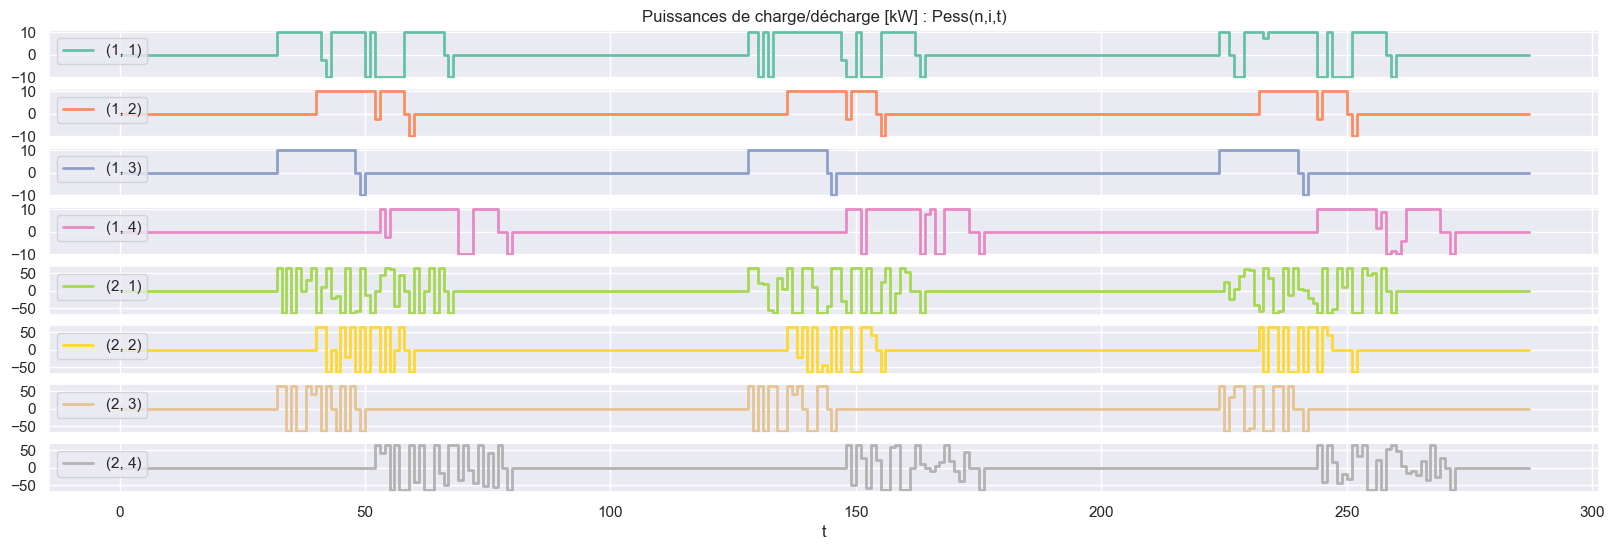

In [184]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pess__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de charge/décharge [kW] : Pess(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

n  i
1  1    0
   2    0
   3    0
   4    0
2  1    0
   2    0
   3    0
   4    0
dtype: int64


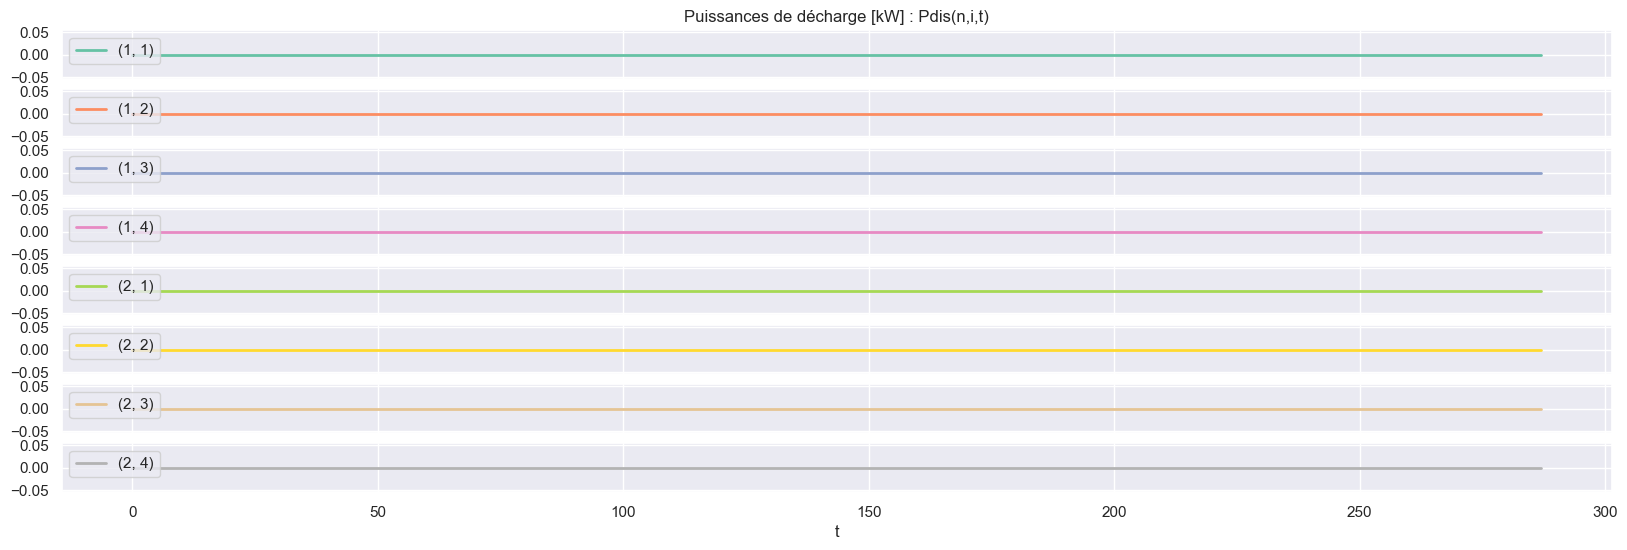

In [185]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pdis__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de décharge [kW] : Pdis(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

n  i
1  1    0
   2    0
   3    0
   4    0
2  1    0
   2    0
   3    0
   4    0
dtype: int64


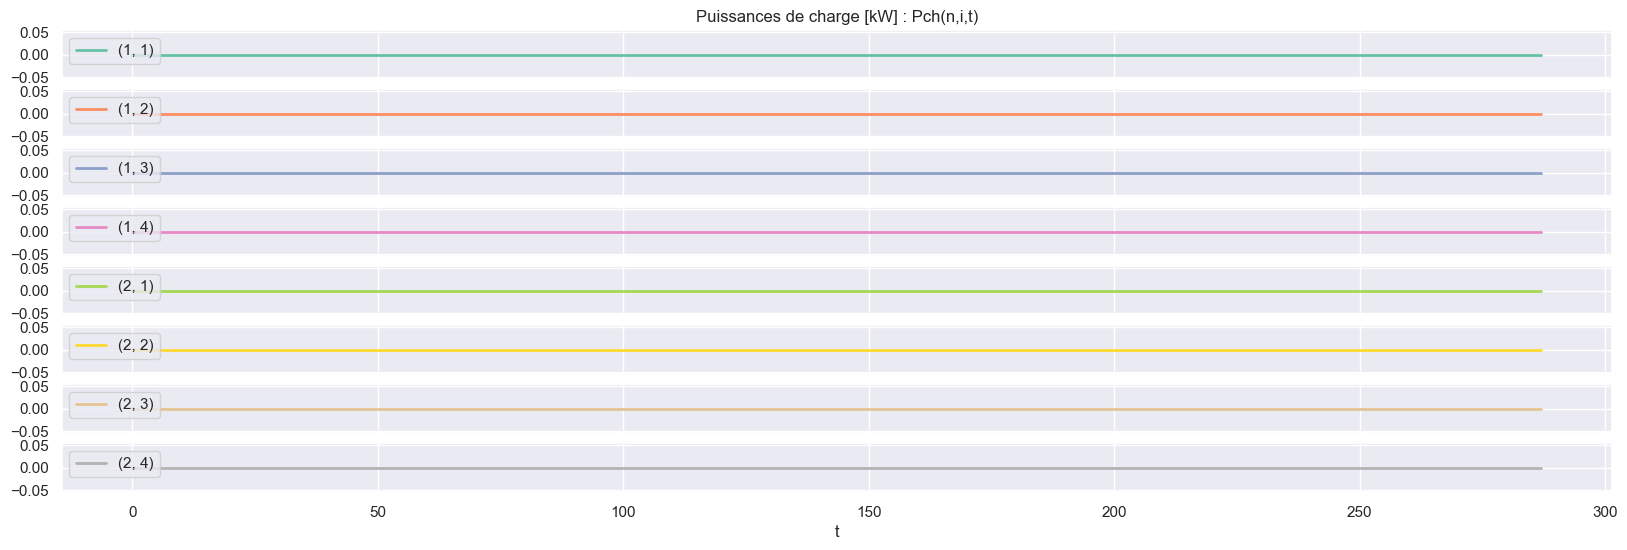

In [172]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de charge [kW] : Pch(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

In [173]:
peak_label = 'is_peak'
above_threshold_label = 'is_above_threshold_label'
timestamp = 'Timestamp'
res = dk.copy(True)
print(res.shape)
res[timestamp] = res.index
res[peak_label] = np.where(res['Pb batiment']>=10000, 1,0)
res[above_threshold_label] = np.where(res['Pr reseau']>=10000, 1,0)

df_time = datetime_attributes(res,column=timestamp)
df_iso = datetime_isocalendar(res,column=timestamp)
dfk = pd.concat([res, df_time, df_iso[['week','weekday','is_workday']]],axis=1)
dfk['year_month'] = year_month_date_to_string(dfk.index)
dfk['month_week'] = 100*dfk['month']+dfk['week']


rep_heure_avant= (15/60) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[peak_label], normalize=False)
rep_heure_apres= (15/60) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[above_threshold_label], normalize=False)

rep_heure_avant['V2B'] = 'Avant'
rep_heure_avant = rep_heure_avant.set_index('V2B', append=True)
rep_heure_apres['V2B'] = 'Apres'
rep_heure_apres = rep_heure_apres.set_index('V2B', append=True)
rep_heure = pd.concat([rep_heure_avant, rep_heure_apres])
#display(rep_heure)

rep_heure = rep_heure.sort_index(ascending=False)
display(rep_heure)

(288, 6)
                     year  week  weekday  is_workday
index                                               
2015-01-12 00:14:00  2015     3        1           1
2015-01-12 00:29:00  2015     3        1           1
2015-01-12 00:44:00  2015     3        1           1
2015-01-12 00:59:00  2015     3        1           1
2015-01-12 01:14:00  2015     3        1           1


month           1
year V2B         
2015 Avant  19.75
     Apres  21.75

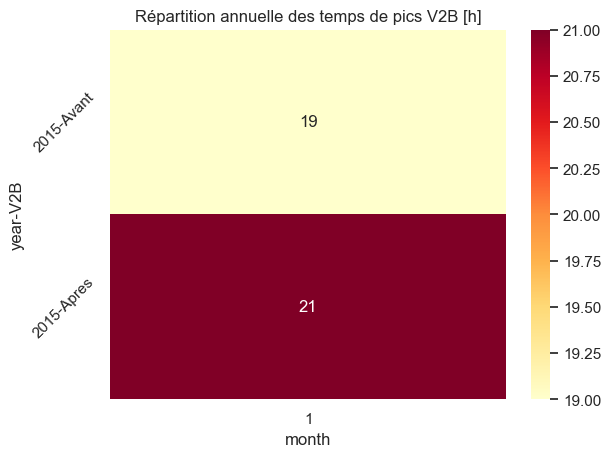

In [174]:
title = "Répartition annuelle des temps de pics V2B [h]"
rep_heure = rep_heure.astype(int)
g = sns.heatmap(rep_heure,cmap="YlOrRd", annot=True, cbar=True, fmt='.0f')
g.set_yticklabels(g.get_yticklabels(), rotation=45)

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.title(title)
plt.show()
fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')

In [147]:
rep_perc_avant= (100) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[peak_label], normalize=True)
rep_perc_apres= (100) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[above_threshold_label], normalize=True)

In [123]:
from docx import Document

def doc_table(doc, tab):
    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(tab.shape[0]+1, tab.shape[1]+1)
    #t.style = 'LightShading-Accent1'
    # add the header rows.
    t.cell(0,0).text = 'index'
    for j in range(tab.shape[-1]):
        t.cell(0,j+1).text = str(tab.columns[j])
    # add the rest of the data frame
    for i in range(tab.shape[0]):
        print(i)
        r = tab.index[i]
        t.cell(i+1,0).text = str(r)
        for j in range(tab.shape[-1]):
            t.cell(i+1,j+1).text = str(tab.values[i,j])

In [124]:
doc = Document()
doc.add_heading('Résumé des informations du problème', 0)

p = doc.add_paragraph('Rborne[n,i]')
t_df = pd.DataFrame(mdl.Rborne__n_i)
doc_table(doc=doc, tab=t_df)
p = doc.add_paragraph('')
#run = p.add_run()
#run.add_break()
doc.add_paragraph('répartition annuelle avant V2B ')
t_rows = rep_perc_avant.round(decimals=1)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')
doc.add_paragraph('répartition annuelle après V2B ')
t_rows = rep_perc_apres.round(decimals=1)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')

#run.add_break(WD_BREAK.PAGE)
doc.add_paragraph('répartition annuelle des temps de pics avant V2B [h]')
t_rows = rep_heure_avant.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')

doc.add_paragraph('répartition annuelle des temps de pics après V2B [h]')
t_rows = rep_heure_apres.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')


# save the doc
doc.save(Path(save_dir, 'tables.docx'))

0
1
0
0
0
0


## END OF MAIN

## TROUBLESHOOTING

i
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64
i
1    0
2    0
3    0
4    0
dtype: int64


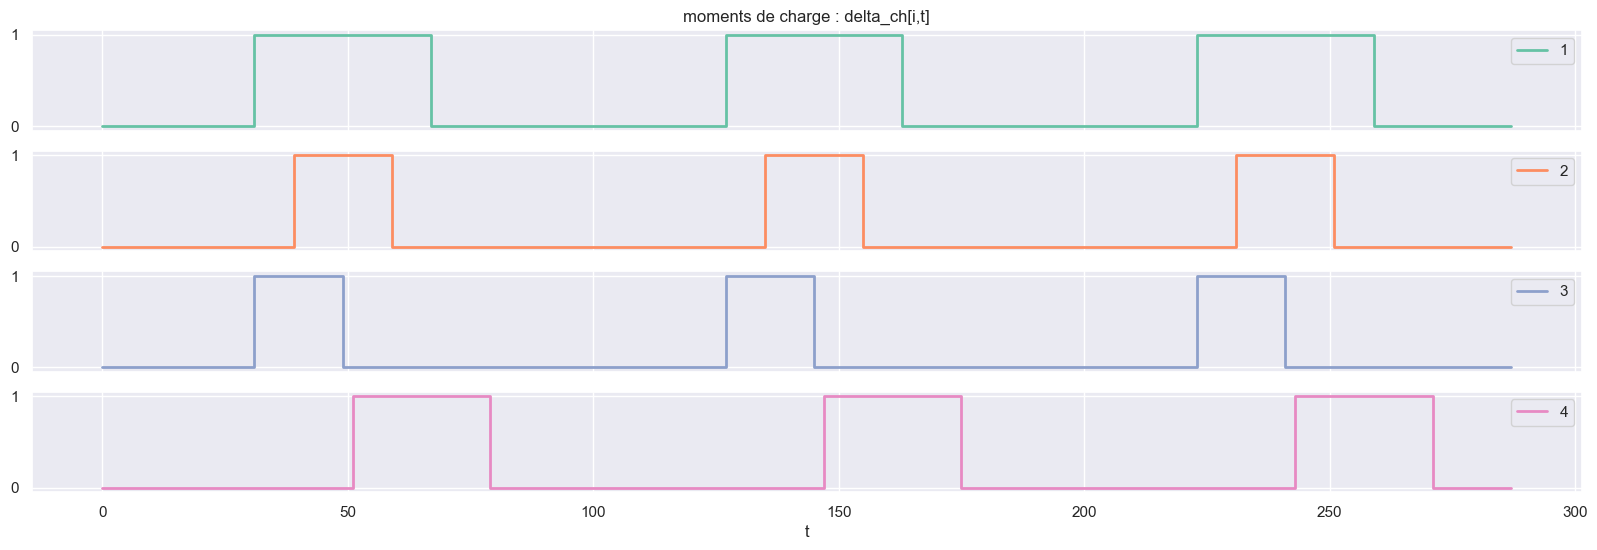

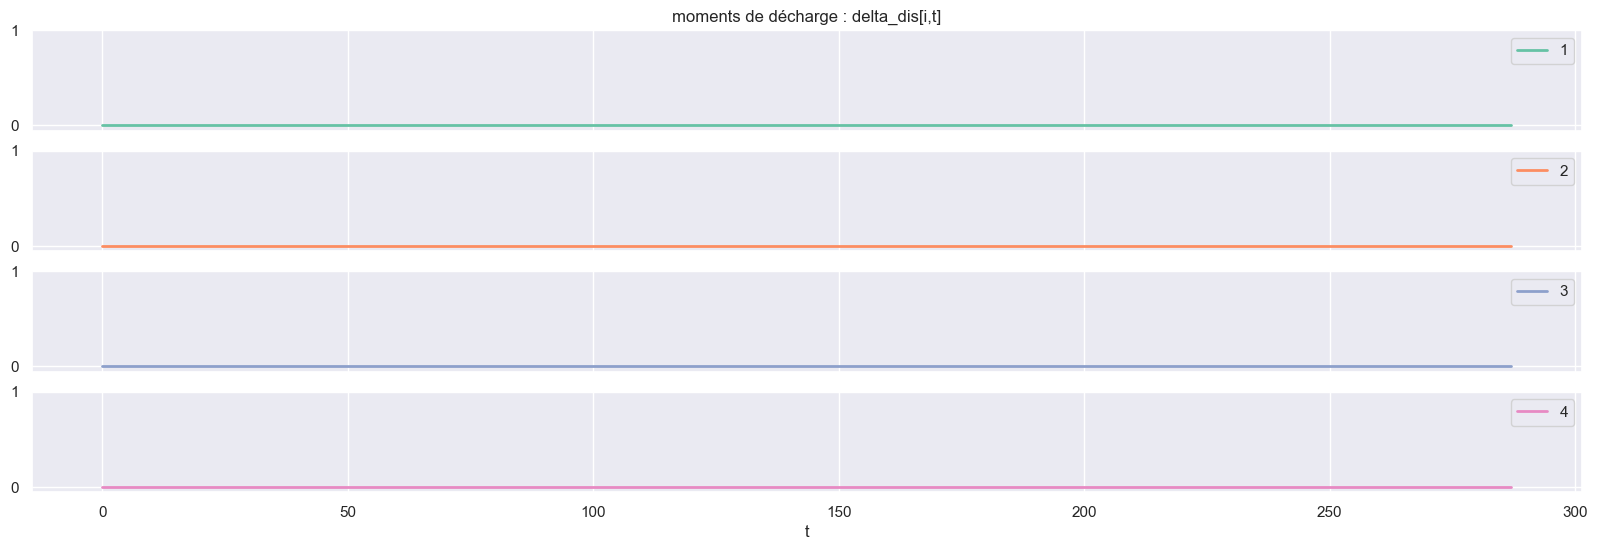

In [125]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.delta_ch__i_t, index='t', columns=['i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('moments de charge : delta_ch[i,t]')
print(df_var.max())
for a in g:
    a.set_yticks([0, 1])
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.delta_dis__i_t, index='t', columns=['i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('moments de décharge : delta_dis[i,t]')
for a in g:
    a.set_yticks([0, 1])
print(df_var.max())
